In [1]:
#imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from levenshtein import *
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from collections import Counter
import seaborn as sns
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 100)
%matplotlib inline

3
8


In [2]:
#functions
def n_studies(x, table):
    'Returns index where non zero in pivot table'
    n_studies = len(table[x].iloc[table[x].nonzero()].index)
    return n_studies

Sequences in this database are collected from various studies either from supplementary material to the original paper or from tables and figures in the paper. The data that is usually available is the sequences/clonotypes that are unique to a group of diseased patients vs the healthy control group. Consequently there is no real knowledge on the specificity of these antibodies or b cells. Another approach is collecting b cells or antibodies from diseased patients and selecting them against a protein or structure specific to the disease and sequencing these hereafter. Sometimes after the initial sequencing the variable heavy chains are cloned into a vector...

In [3]:
# Read data from own file and PIRD database file
own_db_file = Path().cwd() / 'data_in' / 'CDR3_database_original.xlsx' 
PIRD_file = Path().cwd() / 'data_in' / 'PIRD_df.csv' #they added tetanus vaccine

figdir = Path('figdir')

In [4]:
db_own = pd.read_excel(own_db_file, skipinitialspace=True, dtype='object')
db_pird = pd.read_csv(PIRD_file, sep = ';', skipinitialspace=True, dtype='object', header=1)
db_pird['Numbering'] = 'IMGT+CW'
#db_pird['generalized_antigen_repertoire'] = db_pird['Disease.name']

db_own.shape, db_pird.shape

((2655, 25), (570, 32))

In [5]:
#'Anaphylactic shock due to adverse food reaction':'Food Allergy'

In [6]:
#Change column names to concatenate on 
db_pird.rename({'CDR3.heavy.aa':'CDR3', 'Disease.name': 'antigen_disease', 'Vheavy':'V_gene', 'Jheavy':'J_gene'}, axis='columns', inplace=True)
db_pird.drop_duplicates(inplace=True)
db_own.rename({'antigen/disease state':'antigen_disease'}, axis='columns', inplace=True)

In [7]:
# Concatenate two databases
db = pd.concat([db_own, db_pird], sort=False, ignore_index=True)
print(db.shape)
db.drop('author.1', axis=1, inplace=True) #redundant column/has to be removed from source file

db = db.apply(lambda x: x.str.strip()) #copying in excel caused several whitespaces at the end and beginning
db['CDR3'] = db['CDR3'].str.split().str[0] #some entries had other characters left after the sequence, get the first split

db.dropna(subset=['CDR3'], inplace=True)

print(db.shape)

#db.drop([7841], inplace = True)

(3225, 51)
(3190, 50)


In [8]:
s = 'DHWWSFDA' 
b = 'ARDDYNRGVLDS'
c = 'CARGRGVDVMSPLYDNW'

s+'W', b[2:]+'W', c[3:]+'W'

('DHWWSFDAW', 'DDYNRGVLDSW', 'GRGVDVMSPLYDNWW')

In [9]:
#Change KABAT to IMGT with mean AA 'X' and add conserved C start and W end where necessary
#Change IMGT to KABAT no include other LPS!
db.loc[db['Numbering'] == 'KABAT', 'CDR3'] = db.loc[db['Numbering'] == 'KABAT', :]['CDR3'].apply(lambda x: 'CXX'+x+'W')
db.loc[db['Numbering'] == 'IMGT', 'CDR3'] = db.loc[db['Numbering'] == 'IMGT', :]['CDR3'].apply(lambda x: 'C'+x+'W')
#db.loc[db['Numbering'] == 'IMGT+CW', 'CDR3'] = db.loc[db['Numbering'] == 'IMGT+CW', :]['CDR3'].apply(lambda x: x[3:] + 'W')

In [10]:
#After checking CDR numbering schemes in the original papers these were added in the Numbering column
#Most are numbered according to the IMGT numbering 
#Some of these already include the conserved C and W at start and end
#Kabat numbering schemes and unknown have to be dropped because these will mess up edit distances
print(db['Numbering'].value_counts())

#drop wrong numbering
indexNames_wrongnumbering = db[(db['Numbering'] == 'unknown') | (db['Numbering'] == 'KABAT')].index
db.drop(indexNames_wrongnumbering, axis=0, inplace=True)

IMGT       2212
IMGT+CW     816
KABAT        82
unknown      80
Name: Numbering, dtype: int64


In [11]:
print(db['Numbering'].value_counts())

IMGT       2212
IMGT+CW     816
Name: Numbering, dtype: int64


Sequence starts with 'C' and ends with 'W': 3012
Sequence starts with 'C' and ends with 'X': 6
Sequence starts with 'X' and ends with 'W': 8
Sequence starts with 'X' and ends with 'X': 2
3028


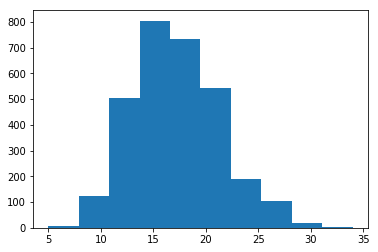

In [12]:
#Check notation

lenCW = len((db[(db['CDR3'].str.startswith('C')) & (db['CDR3'].str.endswith('W'))]))
lenCX = len((db[(db['CDR3'].str.startswith('C')) & ~ (db['CDR3'].str.endswith('W'))]))
lenXW = len((db[(db['CDR3'].str.endswith('W')) & ~ (db['CDR3'].str.startswith('C'))]))
lenXX = len(db[(db['CDR3'].str[0] != 'C') & (db['CDR3'].str[-1] != 'W')])

print("Sequence starts with 'C' and ends with 'W':", lenCW)
print("Sequence starts with 'C' and ends with 'X':", lenCX)
print("Sequence starts with 'X' and ends with 'W':", lenXW)
print("Sequence starts with 'X' and ends with 'X':", lenXX)

sum_ = lenCW + lenCX + lenXW + lenXX

print(sum_)

plt.hist([len(x) for x in db['CDR3']])
plt.show()
plt.close()

In [13]:
# add conserved C at start and conserved W at end where missing (IMGT numbering tag)
#db['CDR3'] = db['CDR3'].apply(lambda x: add_CW_strict(x))

In [14]:
#Look at duplicates from different studies
dbdup = db[db.duplicated(subset=['CDR3'], keep=False)].sort_values(by = 'CDR3')
print(dbdup.shape)
#Find a way for every unique CDR3 to look at wich studies they come from.

(541, 50)


In [15]:
#drop duplicates as they will end up in the same DBSCAN cluster
db.drop_duplicates(subset=['CDR3'], inplace = True, keep='first')
print('Number of duplicates:', len(db[db.duplicated(subset=['CDR3'], keep=False)]))
print(db.shape)

#Some CDR3 entries contain artifacts, remove them
db['CDR3'] = db['CDR3'].str.split().str[0]

indexNames_isnotalpha = db[~db['CDR3'].str.isalpha()].index
db.drop(indexNames_isnotalpha, axis=0, inplace=True)

keep_cols = ['CDR3', 'V_gene', 'J_gene', 'antigen_disease','generalized_antigen_repertoire', 'article_title', 'author']

df = db.filter(keep_cols, axis=1)
df.sort_values(by='generalized_antigen_repertoire', axis=0, inplace=True)

#export studies on LPS/PS for use in classifier
lipopoly = ['capsular polysaccharide (PS) Streptococcus pneumoniae Type 6B-specific',
            'antibody Fab fragments specific for the capsular polysaccharide of Streptococcus pneumoniae serotype 23F',
            'hmAbs after Pneumovax23'
           ]
db_lipopoly = df[df['antigen_disease'].isin(lipopoly)]
print(db_lipopoly.shape)

#lipopoly_to_csv = Path().cwd() / 'data_in' / 'db_lipopoly.csv'
#db_lipopoly.to_csv(lipopoly_to_csv, index=False)


file_to_csv = Path().cwd() / 'data_in' / 'own_db.csv'
df.to_csv(file_to_csv, index=False)

Number of duplicates: 0
(2717, 50)
(62, 7)


In [16]:
#Sort according to 
len(db['CDR3'].unique()), len(db['CDR3'])

(2694, 2694)

In [17]:
# Create distance matrix with levenshtein distance
filename = Path().cwd() / 'data_out' / 'CDR3dbdistmat.txt'
#np.savetxt(filename, create_dist(column=df['CDR3'].values))
dist = np.loadtxt(Path().cwd() / 'data_out' / 'CDR3dbdistmat.txt')
print(dist.shape)
print(np.unique(dist.diagonal())) #check if diagonal is all zero

(2694, 2694)
[0.]


In [18]:
#sort on generalized_antigen_repertoire to get indexes for the repertoires
db.sort_values(by='generalized_antigen_repertoire', axis=0, inplace=True)
db.reset_index(drop=True, inplace=True)
repertoires = db['generalized_antigen_repertoire'].unique()
repertoire_index_range = {}
for x in repertoires:
    index_ = db.index[db['generalized_antigen_repertoire']==x].tolist()
    index_range = len(index_)
    start = np.min(index_)
    end = np.max(index_)
    middle = start + (end-start)/2
    repertoire_index_range[x] = (start,end,middle)

In [19]:
repertoire_index_range['Zika virus']

(2627, 2693, 2660.0)

In [27]:
#get the mean edit distance for a repertoire
def get_mean_distance(d,m,r):
    coord = d[r]
    #mean distance
    rep_dist = m[coord[0]:coord[1], coord[0]:coord[1]]
    sum_dist = np.sum(rep_dist)
    std_dist = np.std(rep_dist[~np.isnan(rep_dist)])
    mean_dist = sum_dist / (rep_dist.size-rep_dist.shape[0])  #diagonal of zeros will affect the mean  
    return mean_dist, std_dist

reps = []
repertoire_lengths, mean_seq_lengths, mean_dist, stds = [], [], [], []
std_repertoire_lengths, std_mean_seq_lengths, std_mean_dist = [], [], []
for x in repertoires:
    length_rep = len(db.loc[db['generalized_antigen_repertoire'] == x])
    if length_rep == 1:
        pass
    else:
        repertoire_lengths.append(length_rep)
        mean_seq_length = np.mean(db.loc[db['generalized_antigen_repertoire'] == x, 'CDR3'].str.len())
        mean_seq_lengths.append(mean_seq_length)
        std_mean_seq_lengths.append(np.std(db.loc[db['generalized_antigen_repertoire'] == x, 'CDR3'].str.len()))
        mean_edit_distance = get_mean_distance(d=repertoire_index_range, m=dist, r=x)[0]
        mean_dist.append(mean_edit_distance)
        stds.append(get_mean_distance(d=repertoire_index_range, m=dist, r=x)[1])
        reps.append(x)
        print(x, length_rep, mean_seq_length, mean_edit_distance)
        
np.mean(mean_seq_lengths), np.std(mean_seq_lengths)
std_mean_seq_lengths

Ataxia telangiectasia 9 18.77777777777778 12.678571428571429
B. antrax 84 16.25 12.87393476344402
Chronic Lymphocytic Leukemia 78 17.243589743589745 13.053656869446343
Colorectal cancer 20 12.5 7.883040935672515
Dengue virus 111 12.981981981981981 6.103753127606339
Ebola virus 3 11.666666666666666 11.0
HIV 59 20.23728813559322 14.571687840290382
Hepatitis C virus 4 21.25 16.0
IgA nephropathy 442 15.54524886877828 11.239342403628118
IgE repertoire 964 17.83609958506224 13.268603614398007
Influenza virus 67 19.417910447761194 13.928671328671328
Pemphigus 489 18.15950920245399 13.872639445248595
RSV 60 18.65 13.496201052016366
Streptococcus pneumoniae 62 14.516129032258064 11.026229508196721
Systemic lupus erythematosus 19 17.842105263157894 12.777777777777779
Tetanus 99 14.626262626262626 11.201136124552914
Tetanus vaccine and Diphtheria vaccine 13 16.846153846153847 12.227272727272727
West Nile virus 43 18.976744186046513 14.340301974448316
Zika virus 67 17.55223880597015 13.05268065268

[2.199887763691481,
 3.8879392264503605,
 4.0924755765319105,
 1.857417562100671,
 1.5595216521289896,
 2.494438257849294,
 2.7267599389083568,
 1.6393596310755,
 3.1728468391589857,
 3.987025604194942,
 4.225541575220943,
 4.553153086719291,
 3.9022429447690716,
 3.559367175921598,
 2.960497075878996,
 3.930162714358081,
 3.3933453846327346,
 4.672972123760524,
 3.906686125130244]

In [21]:
middles = [repertoire_index_range[x][2] for x in repertoire_index_range.keys()]
ends = [repertoire_index_range[x][1] for x in repertoire_index_range.keys()]
starts = [repertoire_index_range[x][0] for x in repertoire_index_range.keys()]
keys = list(repertoire_index_range.keys())
label_keys = ['',
              'B. antrax',
              'Chronic Lymphocytic Leukemia',
              '',
              'Dengue virus',
              '',
              '',
              'HIV',
              '',
              'IgA nephropathy',
              'IgE repertoire',
              'Influenza virus',
              'Pemphigus',
              'RSV',
              'Streptococcus pneumoniae',
              '',
              'Tetanus',
              '',
              'West Nile virus',
              'Zika virus']

In [22]:
keys

['Ataxia telangiectasia',
 'B. antrax',
 'Chronic Lymphocytic Leukemia',
 'Colorectal cancer',
 'Dengue virus',
 'Ebola virus',
 'Food allergy',
 'HIV',
 'Hepatitis C virus',
 'IgA nephropathy',
 'IgE repertoire',
 'Influenza virus',
 'Pemphigus',
 'RSV',
 'Streptococcus pneumoniae',
 'Systemic lupus erythematosus',
 'Tetanus',
 'Tetanus vaccine and Diphtheria vaccine',
 'West Nile virus',
 'Zika virus']

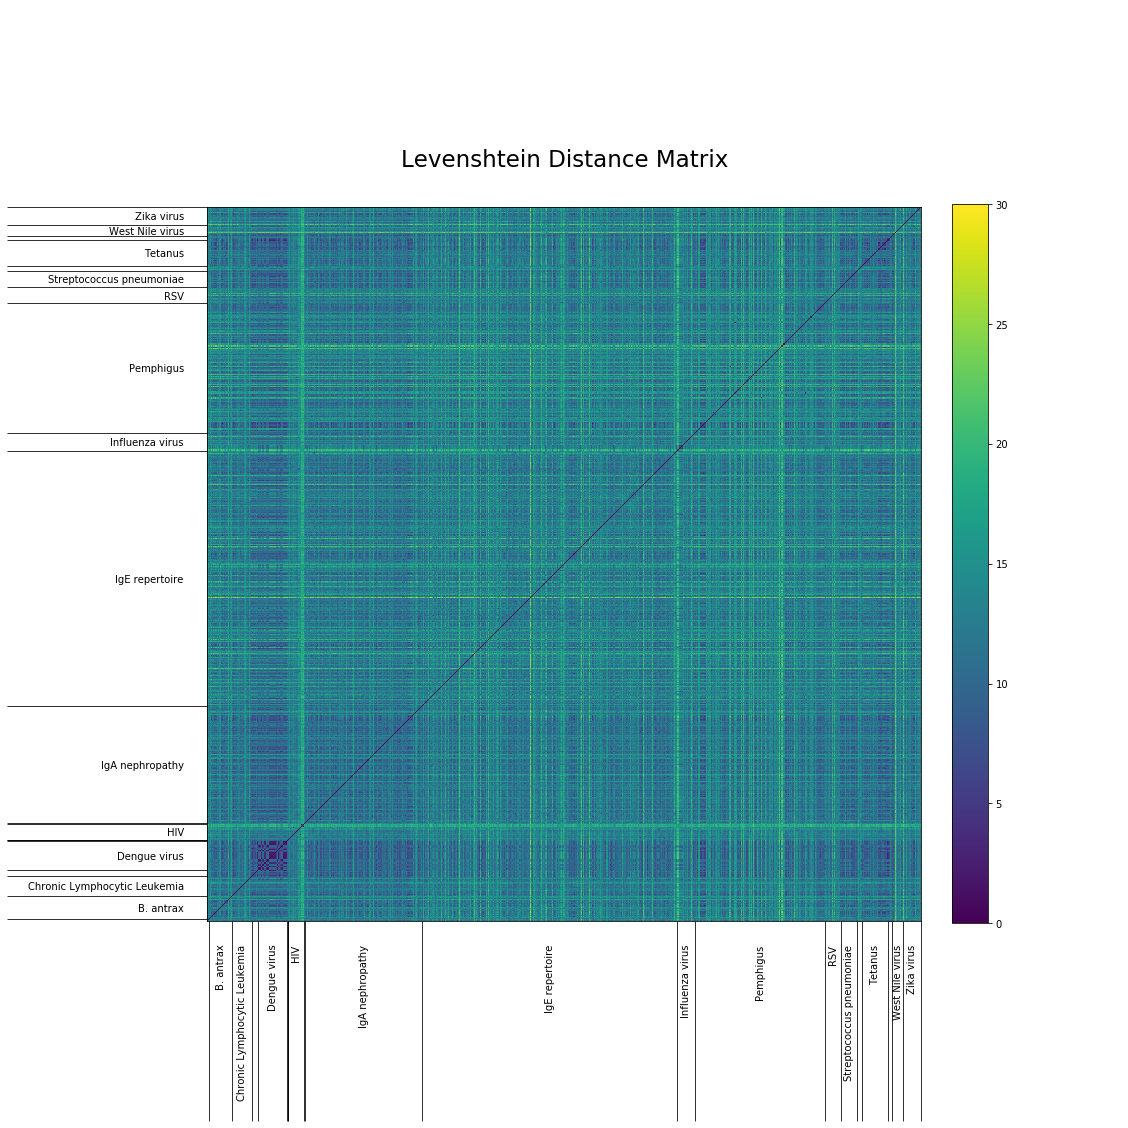

In [23]:
import matplotlib.ticker as ticker
# Very heterogenous plot indicating lot of variation within repertoires
# small darker spot indicating highly similar CDR
# No big clusters to be seen
# light green is more diffences/higher edit distances
# Yellow lines are CDR3s that are very dissimilar compared to all the CDR3 is the database


fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize()
N=dist.shape[0]
ax.pcolormesh(dist, norm = norm, cmap = 'viridis')

#COLORBAR
im = ax.imshow(dist, origin='lower', aspect = 'equal')
fig.colorbar(mappable=im,ax=ax, fraction=0.046, pad=0.04, norm=norm)

#X AXIS
#major ticks: ends of repertoires
ax.xaxis.set_major_locator(ticker.FixedLocator(ends))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
#minor ticks: middles of repertoires to put label
ax.xaxis.set_minor_locator(ticker.FixedLocator(middles))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(label_keys))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_minorticklines(), visible=False) #hide

#Y AXIS
#major ticks: ends of repertoires
ax.yaxis.set_major_locator(ticker.FixedLocator(ends))
ax.yaxis.set_major_formatter(ticker.NullFormatter())
#minor ticks: middles of repertoires to put label
ax.yaxis.set_minor_locator(ticker.FixedLocator(middles))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(label_keys))
#plt.setp(ax.yaxis.get_minorticklabels())
plt.setp(ax.yaxis.get_minorticklines(), visible=False) #hide

plt.title('Levenshtein Distance Matrix', fontsize = 23, pad = 40)

ax.tick_params(which='minor', length =20)
ax.tick_params(which='major', length=200)
ax.axis('scaled')
#plt.draw()
fig_name = figdir/'distance_matrix_plot.jpg'
#plt.savefig(fname = fig_name, bbox_inches="tight")
plt.show()
plt.close()

# DBSCAN CLUSTERING

(2694, 2694)
Epsilon 1 Number of clusters: 87 Noise points: 2381 Clustered sequences 313


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Clusters with different repertoires: 5
Cluster 5 ['Colorectal cancer', 'IgA nephropathy'] 3
Cluster 6 ['Colorectal cancer', 'IgA nephropathy'] 2
Cluster 7 ['Dengue virus', 'Tetanus'] 66
Cluster 12 ['Food allergy', 'IgE repertoire'] 2
Cluster 20 ['IgA nephropathy', 'Streptococcus pneumoniae'] 2


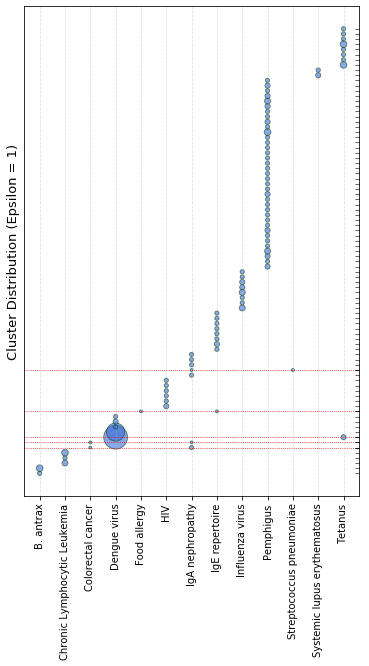

Epsilon 2 Number of clusters: 121 Noise points: 2250 Clustered sequences 444


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Clusters with different repertoires: 15
Cluster 2 ['B. antrax', 'Colorectal cancer', 'IgA nephropathy', 'IgE repertoire', 'Pemphigus', 'Tetanus'] 29
Cluster 8 ['Colorectal cancer', 'IgA nephropathy'] 2
Cluster 9 ['Colorectal cancer', 'Pemphigus'] 2
Cluster 12 ['Colorectal cancer', 'IgE repertoire'] 3
Cluster 13 ['Colorectal cancer', 'IgA nephropathy'] 3
Cluster 14 ['Dengue virus', 'Pemphigus', 'Tetanus', 'Tetanus Diphtheria vaccine'] 71
Cluster 17 ['Dengue virus', 'IgE repertoire', 'West Nile virus'] 3
Cluster 19 ['Dengue virus', 'Zika virus'] 3
Cluster 21 ['Food allergy', 'IgE repertoire'] 2
Cluster 33 ['IgA nephropathy', 'Streptococcus pneumoniae'] 2
Cluster 35 ['IgA nephropathy', 'Pemphigus'] 2
Cluster 36 ['IgA nephropathy', 'IgE repertoire'] 5
Cluster 44 ['IgE repertoire', 'Streptococcus pneumoniae'] 2
Cluster 53 ['IgE repertoire', 'Pemphigus'] 4
Cluster 85 ['Pemphigus', 'RSV'] 2


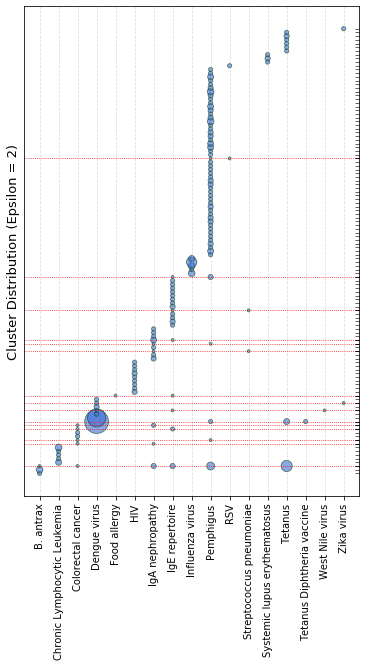

Homogenous clusters (eps = 1, eps = 2: [82, 106]


In [24]:
# eps = 1


clusters = []
noise = []
h_clust = []
avg_clustersize = []
epsilon_dict = {}
range_ = range(1,3)
print(dist.shape)

for i in range_:
    #Clustering Object
    clustering = DBSCAN(eps=i, min_samples=2, metric='precomputed').fit(dist)
    
    #Some metrics
    n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    clusters.append(n_clusters)
    n_noise = list(clustering.labels_).count(-1)
    noise.append(n_noise)
    print('Epsilon',i, 'Number of clusters:', n_clusters, 'Noise points:', n_noise, 'Clustered sequences', (dist.shape[0]-n_noise))
    
    #Copy df to analyze for every epsilon
    df_clust = df.copy()
    
    #Append DBSCAN labels to dataframe
    df_clust['DBSCAN_label'] = clustering.labels_
    
    #Create dict to get percentages clustered and not clustered for every repertoire
    cluster_percentages = {}
    for x in df_clust['generalized_antigen_repertoire'].unique():
        labels_in_repertoire = list(df_clust.loc[df_clust['generalized_antigen_repertoire'] == x,:]['DBSCAN_label'])
        length_repertoire = len(labels_in_repertoire)
        not_clustered = labels_in_repertoire.count(-1)
        precentage_clustered = ((length_repertoire - not_clustered)/length_repertoire)*100
        percentage_not_clustered = (100-precentage_clustered)
        cluster_percentages[x] = (precentage_clustered, percentage_not_clustered)
    
    #For every epsilon the dict from above
    epsilon_dict[i] = cluster_percentages
    
    #Get the clusters without the noise label
    df_clustered = df_clust.loc[df_clust['DBSCAN_label'] != -1, :]
    
    #Get average clustersize over all clusters
    average_cluster_size = np.mean([len(df_clustered.loc[df_clustered['DBSCAN_label'] == x,:]) for x in set(df_clustered['DBSCAN_label'].unique())])
    avg_clustersize.append(average_cluster_size)
    
    #Give value 1 to use with aggfunc=np.sum for pivot table
    df_clustered['count'] = 1
    
    ptable = pd.pivot_table(df_clustered, values='count', index='generalized_antigen_repertoire', columns='DBSCAN_label',
                           aggfunc=np.sum, fill_value=0)
    ptable.rename(index={'Tetanus vaccine and Diphtheria vaccine': 'Tetanus Diphtheria vaccine'}, inplace=True)

    #Get the label of clusters with more than one repertoire (without knowing the repertoires)
    hetero_clusters = [x for x in set(ptable) if n_studies(x=x, table=ptable) != 1]
    print('Clusters with different repertoires:',len(hetero_clusters))
    h_clust.append(len(hetero_clusters))
    
    #Print the different repertoires for every heterogenous cluster in output
    cell_repertoires, cell_sizes = [], [] #To plot table
    for x in hetero_clusters:
        studies = list(ptable.iloc[ptable[x].nonzero()].index)
        size = ptable[x].sum()
        cell_repertoires.append(studies)
        cell_sizes.append(size)
        print('Cluster', x, studies, size)
        
    
    #For every epsilon output figure using meshgrid and pivot table
    fig = plt.figure(figsize=(6,9))
    ax1 = fig.add_subplot(111)
    y,x  = np.meshgrid(range(ptable.shape[1]),range(ptable.shape[0]), indexing='xy')
    ax1.scatter(x[:],y[:],s=ptable.values*9, c='#376CD6', alpha=.6, linewidths=.8, edgecolors= '#033703')
    ax1.set_xticks(np.arange(ptable.shape[0]), minor=False)
    ax1.set_xticklabels(ptable.index, rotation='vertical')
    #small ticks on y axis
    ax1.tick_params(axis='y', which='both', labelleft='on', labelright='on', length = 4, direction = 'in')
    ax1.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(ptable.shape[1])))
    ax1.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax1.yaxis.set_major_locator(ticker.FixedLocator(hetero_clusters))
    ax1.yaxis.set_major_formatter(ticker.NullFormatter())
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(hetero_clusters, minor=True) #where cluster is heterogenous
    ax1.set_yticks(np.arange(ptable.shape[1]), minor=True) #normal ticks
    
    ax1.yaxis.grid(True, which='major', ls=':', alpha=1, c='red')
    ax1.xaxis.grid(True, which='major', ls='--', alpha=.4)
    
    
    title = 'Cluster Distribution (Epsilon = {})'.format(i)
    ax1.set_ylabel(title,fontsize=13)
    
    fig_name = f'DBSCAN_cluster_epsilon={i}_plot.pdf'
    #plt.savefig(fname = figdir / fig_name, bbox_inches='tight')
    plt.show()
    plt.close()
    #ax1.set_title(title, fontsize=13)
    
    #Plot table with heterogenuous clusters
    #table_headers = ('Cluster', 'Repertoires', 'Size')
    #table_rows = ['Cluster {}'.format(x) for x in hetero_clusters]
    #ax2 = fig.add_subplot(122)
    #ax2.axis('tight')
    #ax2.axis('off')
    #ax2.table(cellText = [[a,b,c] for a,b,c in zip(table_rows,cell_repertoires, cell_sizes)],
    #        colLabels = table_headers,
    #         colLoc = 'center',
    #         loc = 'center',
    #         fontsize = 30,)

#number of clusters - heterogenous clusters gives homogenous clusters
homoclust = [a-b for a,b in zip(clusters,h_clust)]
print('Homogenous clusters (eps = 1, eps = 2:', homoclust)

In [25]:
444/2694

0.16481069042316257

In [26]:
len(clustering.labels_)

2694